[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Fine-tune PaliGemma2 on Object Detection Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/README.md)
[![arXiv](https://img.shields.io/badge/arXiv-2412.03555-b31b1b.svg)](https://arxiv.org/abs/2412.03555)

PaliGemma 2 is built by combining the SigLIP-So400m vision encoder with the more recent and capable language models from the Gemma 2 family.

![PaliGemma2 Figure.1](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/paligemma2-1.png)

The authors use a 3-stage training approach similar to the original PaliGemma. In stage 1, they combine the pretrained vision and language model components and train them jointly on a multimodal task mixture. In stage 2, they train the models at higher resolutions of 448px^2 and 896px^2. In stage 3, they fine-tune the models on the target transfer tasks.

PaliGemma 2 models outperform the original PaliGemma at the same resolution and model size. Increasing the model size and resolution generally improves performance across a wide range of tasks, but the benefits differ depending on the task. Some tasks benefit more from increased resolution, while others benefit more from a larger language model.

![PaliGemma2 Figure.2](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/paligemma2-2.png)

Notebook requires A100 with 40GB of VRAM to train.

## Setup

### Configure your API keys

To fine-tune PaliGemma2, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Kaggle API Key under the name `KAGGLE_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.


In [1]:
!nvidia-smi

Thu Apr 24 14:35:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Download dataset from Roboflow Universe

To fine-tune PaliGemma2, prepare your dataset in JSONL format. You can use Roboflow to easily convert any dataset into this format.

### 📦 1. Install required libraries:


In [2]:
!pip install -q roboflow supervision peft bitsandbytes transformers==4.47.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.

### 🔑 2. Set up kaggle and download the dataset:


In [3]:
import kagglehub, pathlib, zipfile

DATA_ROOT = pathlib.Path(
    kagglehub.dataset_download("salmaneunus/mechanical-tools-dataset")
)  # ex : /root/.cache/kagglehub/datasets/salmaneunus/mechanical-tools-dataset/1

print("Dataset root:", DATA_ROOT)

# Les images: DATA_ROOT/'images', les labels YOLO: DATA_ROOT/'labels'



100%|██████████| 652M/652M [00:09<00:00, 69.7MB/s]

Extracting files...


Dataset root: /root/.cache/kagglehub/datasets/salmaneunus/mechanical-tools-dataset/versions/20


In [4]:
!ls -lh /root/.cache/kagglehub/datasets/salmaneunus/mechanical-tools-dataset/versions/20


total 232K
-rw-r--r-- 1 root root 4.0K Apr 24 14:37  Annotated.csv
-rw-r--r-- 1 root root  792 Apr 24 14:37  hammer.csv.csv
drwxr-xr-x 3 root root 4.0K Apr 24 14:37 'Mechanical Tools Image dataset'
-rw-r--r-- 1 root root 202K Apr 24 14:37  Mechanical_Tools_labelled.csv
drwxr-xr-x 3 root root 4.0K Apr 24 14:37  test_data
drwxr-xr-x 3 root root 4.0K Apr 24 14:37  train_data
drwxr-xr-x 3 root root 4.0K Apr 24 14:37  train_data_V2
drwxr-xr-x 3 root root 4.0K Apr 24 14:37  validation_data_V2


# 3️⃣ Générer le JSONL PaLI‑Gemma


In [5]:
import csv, json, cv2
from pathlib import Path

ROOT = Path("/root/.cache/kagglehub/datasets/salmaneunus/mechanical-tools-dataset/versions/20")
IMG_ROOT = ROOT / "Mechanical Tools Image dataset" / "Mechanical Tools Image dataset"

LABELS = {
    "Gasoline Can":  "gasoline_can",
    "Hammer":        "hammer",
    "Pebbles":       "pebble",
    "Rope":          "rope",
    "Screw Driver":  "screwdriver",
    "Toolbox":       "toolbox",
    "Wrench":        "wrench",
    "pliers":        "plier"
}

CSV_FILES = [
    ROOT/"hammer.csv.csv",
    ROOT/"Annotated.csv",
    ROOT/"Mechanical_Tools_labelled.csv"
]

def loc(v,maxv): return f"<loc{int(v/maxv*1023):04d}>"
def bbox_tokens(x1,y1,x2,y2,w,h):
    return f"{loc(y1,h)}{loc(x1,w)}{loc(y2,h)}{loc(x2,w)}"

jsonl=[]
for csv_path in CSV_FILES:
    with open(csv_path, newline='') as f:
        reader = csv.reader(f)
        for row in reader:
            label,x1,y1,x2,y2,filename,w,h = row[:8]
            label = label.strip()
            cls  = LABELS.get(label, label.lower().replace(" ","_"))

            # retrouver l'image
            img_path = None
            for folder in LABELS.keys():
                candidate = IMG_ROOT/folder/filename
                if candidate.exists():
                    img_path = candidate
                    break
            if img_path is None:
                continue  # image introuvable

            w,h = int(w),int(h); x1,y1,x2,y2 = map(int,(x1,y1,x2,y2))
            tokens = bbox_tokens(x1,y1,x2,y2,w,h)
            jsonl.append(json.dumps({
                "image": img_path.relative_to(ROOT).as_posix(),
                "prefix": "detect " + " ; ".join(sorted(set(LABELS.values()))),
                "suffix": f"{tokens} {cls}"
            }))

PA_DIR = ROOT/"dataset"; PA_DIR.mkdir(exist_ok=True)
jsonl_file = PA_DIR/"_annotations.train.jsonl"
jsonl_file.write_text("\n".join(jsonl))
print("✅ JSONL généré :", jsonl_file, "| lignes :", len(jsonl))


✅ JSONL généré : /root/.cache/kagglehub/datasets/salmaneunus/mechanical-tools-dataset/versions/20/dataset/_annotations.train.jsonl | lignes : 440


NOTE: Let's read the first few lines of the annotation file and examine the dataset format.

In [6]:
!ls -lh /root/.cache/kagglehub/datasets/salmaneunus/mechanical-tools-dataset/versions/20/dataset


total 116K
-rw-r--r-- 1 root root 115K Apr 24 14:38 _annotations.train.jsonl


In [7]:
ROOT = "/root/.cache/kagglehub/datasets/salmaneunus/mechanical-tools-dataset/versions/20"
!apt-get -qq install tree
# 1. Afficher la structure (2 niveaux) :
!tree -L 2 {ROOT}


Selecting previously unselected package tree.
(Reading database ... 126333 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
/root/.cache/kagglehub/datasets/salmaneunus/mechanical-tools-dataset/versions/20
├── Annotated.csv
├── dataset
│   └── _annotations.train.jsonl
├── hammer.csv.csv
├── Mechanical Tools Image dataset
│   └── Mechanical Tools Image dataset
├── Mechanical_Tools_labelled.csv
├── test_data
│   └── test_data
├── train_data
│   └── train_data
├── train_data_V2
│   └── train_data_V2
└── validation_data_V2
    └── validation_data_V2

11 directories, 4 files


In [ ]:
!wc -l {jsonl_file}              # nombre d'annotations
!head -n 5 {jsonl_file}          # aperçu


In [8]:
!head -n 5 /root/.cache/kagglehub/datasets/salmaneunus/mechanical-tools-dataset/versions/20/dataset/_annotations.train.jsonl


{"image": "Mechanical Tools Image dataset/Mechanical Tools Image dataset/Hammer/000002.jpg", "prefix": "detect gasoline_can ; hammer ; pebble ; plier ; rope ; screwdriver ; toolbox ; wrench", "suffix": "<loc0045><loc0032><loc0955><loc0972> hammer"}
{"image": "Mechanical Tools Image dataset/Mechanical Tools Image dataset/Hammer/000003.jpg", "prefix": "detect gasoline_can ; hammer ; pebble ; plier ; rope ; screwdriver ; toolbox ; wrench", "suffix": "<loc0009><loc0040><loc0959><loc0968> hammer"}
{"image": "Mechanical Tools Image dataset/Mechanical Tools Image dataset/Hammer/000003.jpg", "prefix": "detect gasoline_can ; hammer ; pebble ; plier ; rope ; screwdriver ; toolbox ; wrench", "suffix": "<loc0750><loc0709><loc0000><loc0000> hammer"}
{"image": "Mechanical Tools Image dataset/Mechanical Tools Image dataset/Hammer/000004.jpg", "prefix": "detect gasoline_can ; hammer ; pebble ; plier ; rope ; screwdriver ; toolbox ; wrench", "suffix": "<loc0050><loc0159><loc0850><loc0668> hammer"}
{"im

### Set up and test data loaders

### Step 1: Define the Dataset Class

In [9]:
import os
import json
from PIL import Image
from torch.utils.data import Dataset

class JSONLDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self):
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx: int):
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")
        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        image = Image.open(image_path)
        return image, entry


###  Create the Train, Validation, and Test Datasets
Now, we load the training, validation, and test datasets using the JSONLDataset class. Since your annotations are split into different files (train.jsonl, valid.jsonl, and test.jsonl), you can load them similarly.

In [10]:
import json
import random
from pathlib import Path

# Load the train dataset
train_file_path = Path("/root/.cache/kagglehub/datasets/salmaneunus/mechanical-tools-dataset/versions/20/dataset/_annotations.train.jsonl")
valid_file_path = Path("/root/.cache/kagglehub/datasets/salmaneunus/mechanical-tools-dataset/versions/20/dataset/_annotations.valid.jsonl")
test_file_path = Path("/root/.cache/kagglehub/datasets/salmaneunus/mechanical-tools-dataset/versions/20/dataset/_annotations.test.jsonl")

# Read the original training dataset
with open(train_file_path, 'r') as f:
    data = f.readlines()

# Shuffle the data (optional, for random splitting)
random.shuffle(data)

# Calculate the split sizes
total = len(data)
train_size = int(0.7 * total)  # 70% for training
valid_size = int(0.15 * total)  # 15% for validation
test_size = total - train_size - valid_size  # remaining 15% for testing

# Split the data into train, valid, and test
train_data = data[:train_size]
valid_data = data[train_size:train_size + valid_size]
test_data = data[train_size + valid_size:]

# Write the split data to corresponding files
with open(valid_file_path, 'w') as f:
    f.writelines(valid_data)

with open(test_file_path, 'w') as f:
    f.writelines(test_data)

print(f"Validation file created: {valid_file_path}")
print(f"Test file created: {test_file_path}")


Validation file created: /root/.cache/kagglehub/datasets/salmaneunus/mechanical-tools-dataset/versions/20/dataset/_annotations.valid.jsonl
Test file created: /root/.cache/kagglehub/datasets/salmaneunus/mechanical-tools-dataset/versions/20/dataset/_annotations.test.jsonl


In [11]:
# Define the correct paths
ROOT = Path("/root/.cache/kagglehub/datasets/salmaneunus/mechanical-tools-dataset/versions/20")
PA_DIR = ROOT / "dataset"  # This is where your JSONL files are located

# Set up the datasets
train_dataset = JSONLDataset(
    jsonl_file_path=PA_DIR / "_annotations.train.jsonl",
    image_directory_path=ROOT #This is changed! Removed unnecessary redundant path.
)


# Set up the datasets after generating valid and test JSONL files
valid_dataset = JSONLDataset(
    jsonl_file_path=PA_DIR / "_annotations.valid.jsonl",
    image_directory_path=ROOT #This is changed! Removed unnecessary redundant path.
)

test_dataset = JSONLDataset(
    jsonl_file_path=PA_DIR / "_annotations.test.jsonl",
    image_directory_path=ROOT #This is changed! Removed unnecessary redundant path.
)

100%|██████████| 25/25 [00:00<00:00, 287.05it/s]


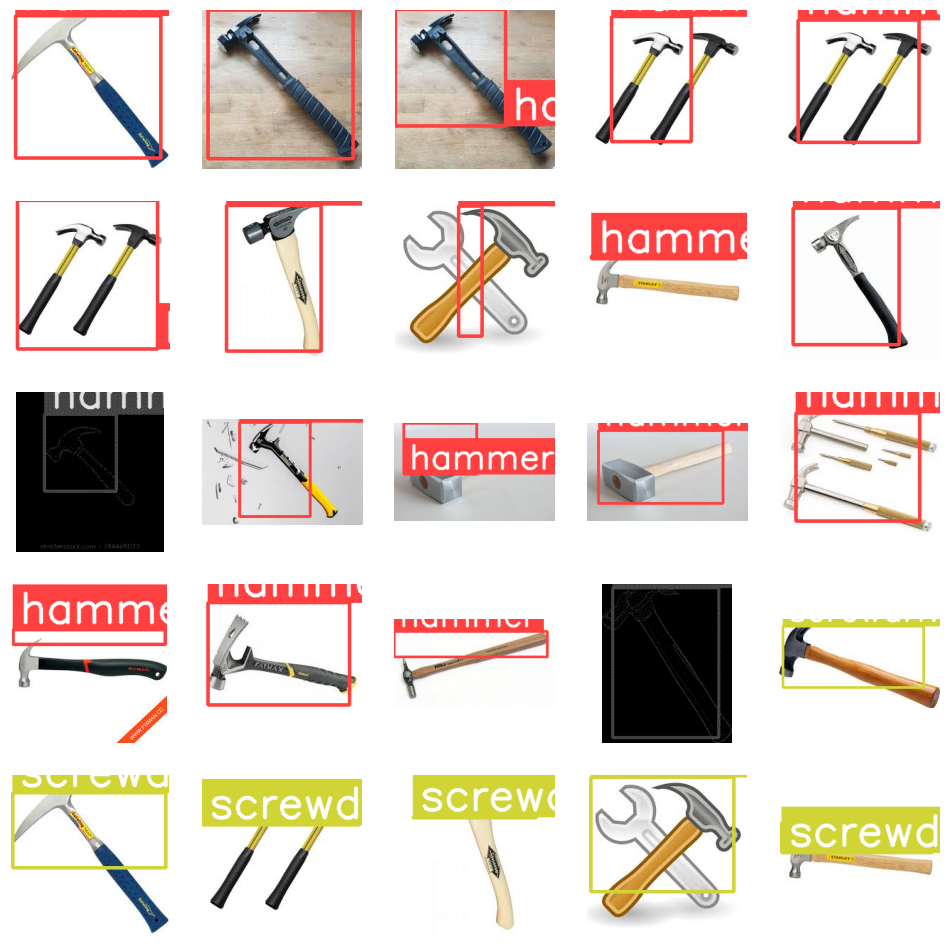

In [12]:
from tqdm import tqdm
import supervision as sv
from PIL import Image

# Define the classes for detection
CLASSES = train_dataset[0][1]['prefix'].replace("detect ", "").split(" ; ")

images = []

for i in tqdm(range(25)):
    # Get image and label from dataset
    image, label = train_dataset[i]

    # Extract bounding box details from the label
    # Ensure 'suffix' contains bounding box info and class information
    result = label["suffix"]  # The actual annotation result containing bounding box data

    # Parse bounding box tokens (assuming 'result' is formatted correctly)
    detections = sv.Detections.from_lmm(
        lmm='paligemma',  # Assuming paligemma gives the proper annotations for detection
        result=result,  # The actual annotation result (bounding box info)
        resolution_wh=(image.width, image.height),  # Image resolution for proper bounding box scaling
        classes=CLASSES  # Use the class names for detection
    )

    # Annotate the image with bounding boxes
    image_with_boxes = sv.BoxAnnotator(thickness=4).annotate(image, detections)

    # Annotate with labels
    image_with_labels = sv.LabelAnnotator(text_scale=2, text_thickness=4).annotate(image_with_boxes, detections)

    # Add the annotated image to the list
    images.append(image_with_labels)

# Plot the images in a grid (5x5 grid for 25 images)
sv.plot_images_grid(images, (5, 5))


### Load PaliGemma2 model

**NOTE:** PaliGemma2 offers 9 pre-trained models with sizes of `3B`, `10B`, and `28B` parameters, and resolutions of `224`, `448`, and `896` pixels. In this tutorial, I'll be using the [`google/paligemma2-3b-pt-448`](https://huggingface.co/google/paligemma2-3b-pt-448) checkpoint. Resolution has a key impact on the mAP of the trained model, and it seems that `448` offers the most optimal balance between performance and compute resources required to train the model.

### Install Dependencies

In [13]:
!pip install transformers torch huggingface_hub


### Log in to Hugging Face

### Load the Model and Processor

In [14]:
import torch
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration

MODEL_ID ="google/paligemma2-3b-pt-448"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
from huggingface_hub import notebook_login
notebook_login()

In [16]:
processor = PaliGemmaProcessor.from_pretrained(MODEL_ID)

preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

**NOTE:** Depending on the multimodal task you are trying to solve, we have prepared two training versions that optimize VRAM consumption.

- Freeze the image encoder and fine-tune only the text decoder.
- Fine-tune the entire model with LoRA and QLoRA.

In [17]:
# @title Freeze the image encoder


TORCH_DTYPE = torch.bfloat16

model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, torch_dtype=TORCH_DTYPE).to(DEVICE)

for param in model.vision_tower.parameters():
    param.requires_grad = False

for param in model.multi_modal_projector.parameters():
    param.requires_grad = False

config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/75.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [19]:
# @title Fine-tune the entire model with LoRA and QLoRA

# ──────────────────────────────────
# A. ajouter LoRA + QLoRA au modèle déjà gelé
# ──────────────────────────────────
from transformers import BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
import torch, os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"  # limite fragmentation

bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        paged_attention=True
)

lora_config = LoraConfig(
        r=8,
        lora_alpha=16,  # Change 'alpha' to 'lora_alpha'
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                        "gate_proj","up_proj","down_proj"],
        task_type="CAUSAL_LM"
)

# « model » existe déjà (chargé + vision_tower gelé)
model = get_peft_model(model, lora_config)     # ajoute LoRA
model.print_trainable_parameters()

TORCH_DTYPE = torch.float16                   # compute dtype utilisé plus bas


Unused kwargs: ['paged_attention']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


trainable params: 11,876,352 || all params: 3,045,003,504 || trainable%: 0.3900


### Fine-tune PaliGemma2 on custom object detection dataset

In [34]:
from transformers import TrainingArguments, Trainer
import random
import torch

# ---------- helpers --------------------------------------------------------
def shuffle_suffix(s: str) -> str:
    parts = s.split(" ; ")
    random.shuffle(parts)
    return " ; ".join(parts)

def collate_fn(batch):
    images, labels = zip(*batch)
    prefixes = ["<image>" + l["prefix"] for l in labels]
    suffixes = [shuffle_suffix(l["suffix"]) for l in labels]
    return processor(
        text=prefixes,
        images=list(images),
        suffix=suffixes,
        return_tensors="pt",
        padding="longest"
    ).to(torch.float16).to(DEVICE)  # fp16 activations on GPU

# ---------------------------------------------------------------------------
# Ensure model parameters require gradients
for param in model.parameters():
    param.requires_grad = True

# Set the model to training mode
model.train()

# Adjusted training arguments to reduce memory usage
args = TrainingArguments(
    output_dir="paligemma2_object_detection",
    num_train_epochs=8,  # start smaller; tune later
    per_device_train_batch_size=1,  # reduce the batch size
    gradient_accumulation_steps=16,  # accumulate gradients over more steps
    learning_rate=2e-5,
    fp16=True,  # continue using mixed precision
    gradient_checkpointing=True,  # reduce memory usage during training
    remove_unused_columns=False,
    warmup_steps=100,
    weight_decay=1e-6,
    logging_steps=50,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=1,
    dataloader_pin_memory=False,  # avoid CUDA pin‑mem error
    report_to=["tensorboard"]  # no wandb prompt
)

# Manually clear the GPU memory before training
torch.cuda.empty_cache()

trainer = Trainer(
    model=model,  # LoRA‑wrapped, vision‑tower frozen
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    args=args,
)

trainer.train()



OutOfMemoryError: CUDA out of memory. Tried to allocate 1.01 GiB. GPU 0 has a total capacity of 14.74 GiB of which 604.12 MiB is free. Process 6501 has 14.15 GiB memory in use. Of the allocated memory 12.24 GiB is allocated by PyTorch, and 1.77 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)